# Autoencoder
John Ignacio R.M. 2020-05-21

In [80]:
import pandas as pd
from glob import glob
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada import (get_trainvaltest_from_dataset, KerasModelGamma, drop_twodim, filter_region, classify_events, signal_distribution_per)
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l1
from keras.callbacks import TensorBoard

from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, roc_auc_score,
precision_recall_curve, average_precision_score)

In [2]:
data_path = "../processed_data"
signal = "Xtohh2000"

In [3]:
x_train, x_val, x_test, y_train, y_val, y_test, w_train, w_val, w_test = get_trainvaltest_from_dataset(data_path, signal, region = "SR", tag = 1, train_size = 0.6, val_size = 0.2, test_size = 0.2, seed = 420)

In [45]:
#dividing the classes
x_train_0 = x_train[y_train == 0]
x_train_1 = x_train[y_train == 1]
w_train_0 = w_train[(y_train == 0).ravel()]
w_train_1 = w_train[(y_train == 1).ravel()]

x_val_0 = x_val[y_val == 0]
x_val_1 = x_val[y_val == 1]
w_val_0 = w_val[(y_val == 0).ravel()]
w_val_1 = w_val[(y_val == 1).ravel()]

In [58]:
#autoencoder
n_features = x_train.shape[1]

input_layer = Input(shape=(n_features, ))
encoder_1 = Dense(8, activation="relu", activity_regularizer=l1(1e-2))(input_layer)
encoder_2 = Dense(4, activation="relu")(encoder_1)
latent = Dense(2, activation="relu")(encoder_2)
decoder_1 = Dense(4, activation="relu")(latent)
decoder_2 = Dense(8, activation="relu")(decoder_1)
output_layer = Dense(n_features, activation="sigmoid")(decoder_2)

autoencoder = Model(inputs = input_layer, outputs=output_layer)
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 14)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 120       
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_32 (Dense)             (None, 14)                126 

In [59]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

In [60]:
history = autoencoder.fit(
    x_train_0, x_train_0, sample_weight = w_train_0,
    epochs=200,
    batch_size=128,
    validation_data=(x_val_0, x_val_0, w_val_0),
    verbose=1,
).history


1933/1933 [==============================] - 0s 16us/step - loss: 1.4594 - val_loss: 1.4363
Epoch 13/200
1933/1933 [==============================] - 0s 19us/step - loss: 1.3273 - val_loss: 1.3030
Epoch 14/200
1933/1933 [==============================] - 0s 15us/step - loss: 1.1992 - val_loss: 1.1797
Epoch 15/200
1933/1933 [==============================] - 0s 19us/step - loss: 1.0822 - val_loss: 1.0621
Epoch 16/200
1933/1933 [==============================] - 0s 16us/step - loss: 0.9743 - val_loss: 0.9517
Epoch 17/200
1933/1933 [==============================] - 0s 16us/step - loss: 0.8695 - val_loss: 0.8458
Epoch 18/200
1933/1933 [==============================] - 0s 17us/step - loss: 0.7726 - val_loss: 0.7477
Epoch 19/200
1933/1933 [==============================] - 0s 15us/step - loss: 0.6818 - val_loss: 0.6539
Epoch 20/200
1933/1933 [==============================] - 0s 19us/step - loss: 0.5918 - val_loss: 0.5704
Epoch 21/200
1933/1933 [==============================] - 0s 13us/s

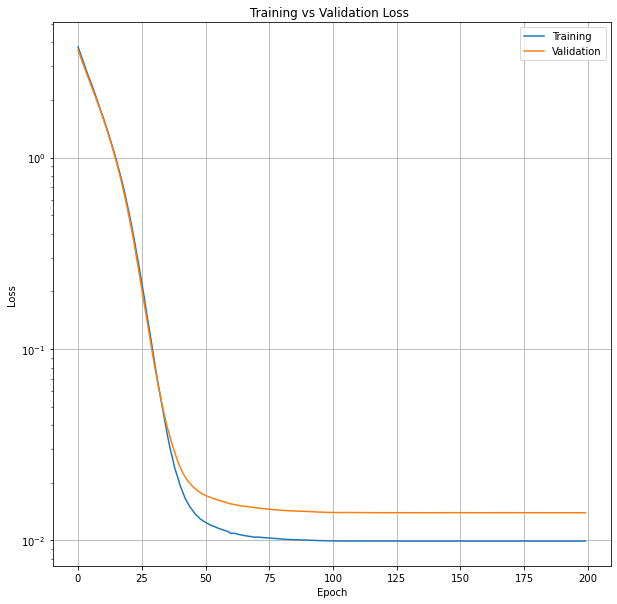

In [66]:
#data
train_loss = history['loss']
val_loss = history['val_loss']
epochs = len(train_loss)
#plot
plt.figure(1, figsize=(10, 10))
plt.plot(range(epochs), train_loss)
plt.plot(range(epochs), val_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training vs Validation Loss ")
plt.grid(True)
plt.legend(['Training', 'Validation'])
plt.yscale('log')
plt.show()

In [86]:
val_scores = autoencoder.predict(x_val)
val_mse = np.mean(np.power(x_val - val_scores, 2), axis=1)

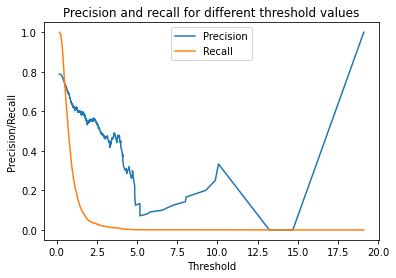

In [89]:
error_val = pd.DataFrame({'Reconstruction_error': val_mse, 'True_class': y_val.ravel()})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_val.True_class, error_val.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision")
plt.plot(threshold_rt, recall_rt[1:], label="Recall")
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [90]:
test_scores = autoencoder.predict(x_test)
test_mse = np.mean(np.power(x_test - test_scores, 2), axis=1)

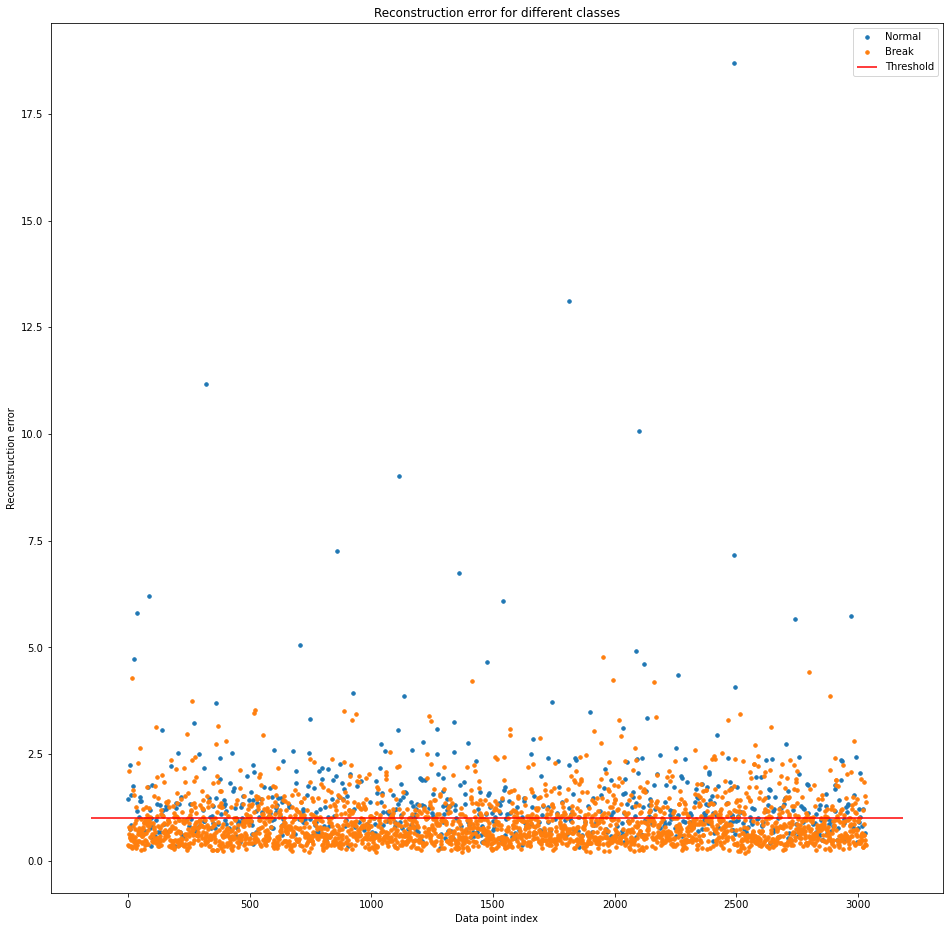

In [102]:
error_test = pd.DataFrame({'Reconstruction_error': test_mse, 'True_class': y_test.ravel()})
error_test = error_test.reset_index()
threshold_fixed = 0.4
groups = error_test.groupby('True_class')
fig, ax = plt.subplots(figsize=(16, 16))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='', label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [ ]:
#calculate metrics
#try tag 0
#try tag 2 searching bg
#make a class for autoencoder